In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
%%capture
!pip install pydub
!pip install noisereduce
!pip install SpeechRecognition


In [ ]:
import os
import pandas as pd
import numpy as np

from pydub import AudioSegment, effects
import librosa
import noisereduce as nr

import matplotlib.pyplot as plt
from librosa import display
import IPython.display as ipd

from pydub.effects import normalize
from scipy.io import wavfile
import noisereduce as nr

In [ ]:
import warnings
import multiprocessing as mp
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv1D, GlobalMaxPooling1D,  MaxPooling1D
from tensorflow.keras.layers import AveragePooling1D,Input, Flatten, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam


In [ ]:
# Define file path for a single file.
file_1 = '/content/drive/My Drive/AudioFiles/RAVDESS/Actor_14/03-01-01-01-01-01-14.wav'

In [ ]:
# Define file path for a single file.
RAVDESS = '/content/drive/My Drive/AudioFiles/RAVDESS/'

In [ ]:
# Define the path
#RAVDESS_PATH = "C:/Users/CHANUL/Downloads/archive/audio_speech_actors_01-24/Actor_01/"

# List files in the directory
files = os.listdir(RAVDESS)

# Print the list of files
print(files)


['Actor_02', '.ipynb_checkpoints', 'Actor_01', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [ ]:
# define the attribute of the file
# 01 = netural, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised
path_list = []
gender = []
emotion_list = []
emotion = {
    '03' : 'happy',
    '01' : 'neutral',
    '02' : 'neutral',
    '04' : 'sad',
    '05' : 'angry',
    '06' : 'fearful',
    '07' : 'disgust',
    '08' : 'surprised'
}
# The input file is in the f

In [ ]:
# append the values of files, gender and emotion
for directory in os.listdir(RAVDESS):
    # reading the data from the actors file
    actor = os.listdir(os.path.join(RAVDESS, directory))

    # read the audio files actor file
    for file in actor:
        part = file.split('.')[0]
        # get the key of the emotion and match with the emotion dictionary
        key = part.split('-')[2]
#         print(key)
        if key in emotion:
            gender_code = int(part.split('-')[6])
            path_list.append(f"{RAVDESS}{directory}/{file}")
            gender.append('female' if gender_code & 1 == 0 else 'male')
            emotion_list.append(emotion[key])

In [ ]:
# make the dataframe of the lists
df = pd.DataFrame({
    'File_Name' : path_list,
    'gender' : gender,
    'emotion' : emotion_list
})

# print the 5 rows of the data
df.head()

File_Name  gender    emotion
0  /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female    neutral
1  /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female  surprised
2  /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female  surprised
3  /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female  surprised
4  /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female  surprised

In [ ]:
import speech_recognition as sr

# Load the RAVDESS dataset into a DataFrame
df = df

# Function to transcribe audio file to text
def transcribe_audio(audio_file):
    recognizer = sr.Recognizer()
    with sr.AudioFile(audio_file) as source:
        audio_data = recognizer.record(source, duration=None)  # Record the entire audio file
    try:
        text = recognizer.recognize_google(audio_data)
        return text
    except sr.UnknownValueError:
        return ""

# Apply transcription to each audio file path in the DataFrame
df['transcription'] = df['File_Name'].apply(transcribe_audio)

# Save transcriptions to a new file or DataFrame
df.to_csv("ravdess_data_with_transcriptions.csv", index=False)

In [ ]:
df

File_Name  gender    emotion  \
0     /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female    neutral   
1     /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female  surprised   
2     /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female  surprised   
3     /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female  surprised   
4     /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female  surprised   
...                                                 ...     ...        ...   
1335  /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female    neutral   
1336  /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female    neutral   
1337  /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female      angry   
1338  /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female      angry   
1339  /content/drive/My Drive/AudioFiles/RAVDESS/Act...  female      angry   

                     transcription  
0     kids are talking by the door  
1     dogs are sitting by the door  
2     dogs are sitting by the door  
3     dogs are sitting by the door  
4     kids are talking by the door  
...                            ...  
1335  dogs are sitting by the door  
1336  dogs are sitting by the door  
1337  dogs are sitting by the door  
1338  kids are talking by the door  
1339  dogs are sitting by the door  

[1340 rows x 4 columns]

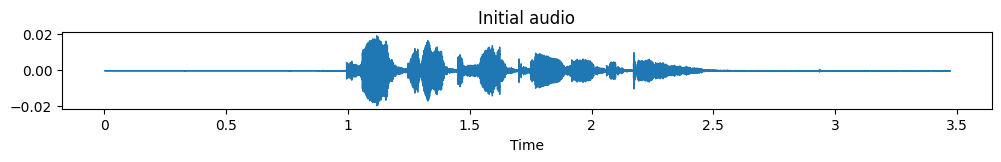

In [ ]:
#Load the audio file into an 'AudioSegment' object, and extract the sample rate.

rawsound = AudioSegment.from_file(file_1)
x, sr = librosa.load(file_1, sr = None)

plt.figure(figsize=(12,1))
librosa.display.waveshow(x, sr = sr)
plt.title('Initial audio')

rawsound

In [ ]:
sr

48000

In [ ]:
len(x)

166566

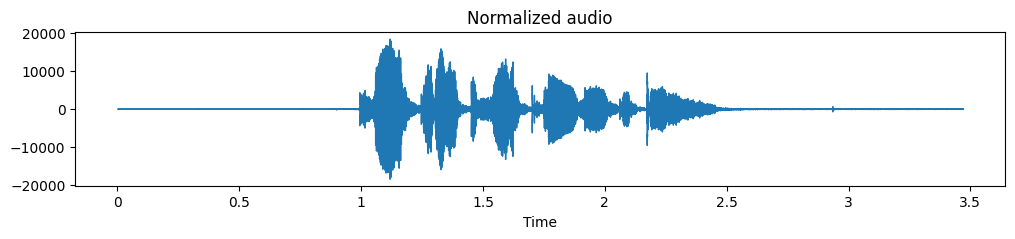

In [ ]:
#Normalize to +5.0 dBFS, Transform audio signals to an array.

normalizedsound = effects.normalize(rawsound, headroom = 5.0)
normal_x = np.array(normalizedsound.get_array_of_samples(), dtype = 'float32')

plt.figure(figsize=(12,2))
librosa.display.waveshow(normal_x, sr = sr)
plt.title('Normalized audio')

normalizedsound

In [ ]:
len(normal_x)

166566

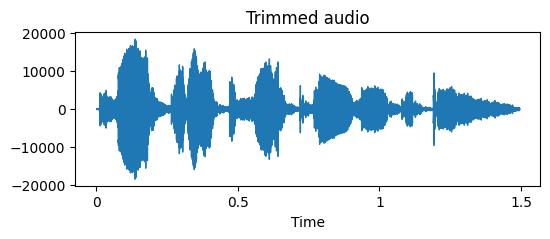

In [ ]:
# 3. Trim silence in the beginning and end.

xt, index = librosa.effects.trim(normal_x, top_db = 30)

plt.figure(figsize=(6,2))
librosa.display.waveshow(xt, sr = sr)
plt.title('Trimmed audio')

ipd.display(ipd.Audio(data = xt, rate=sr))

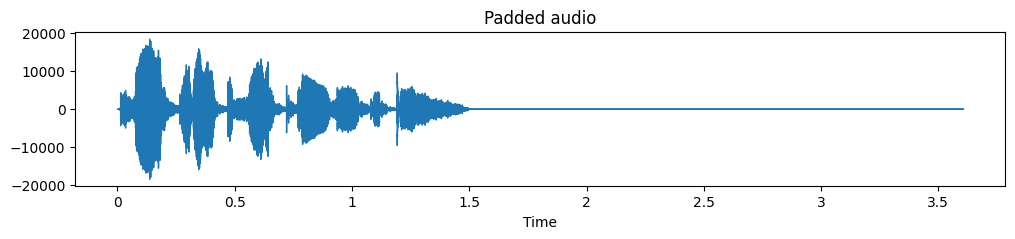

In [ ]:
#Right-side padding for length equalization to align with the maximum lengthed audio

padded_x = np.pad(xt, (0, 173056-len(xt)), 'constant')

plt.figure(figsize=(12,2))
librosa.display.waveshow(padded_x, sr = sr)
plt.title('Padded audio')

ipd.display(ipd.Audio(data = padded_x, rate=sr))

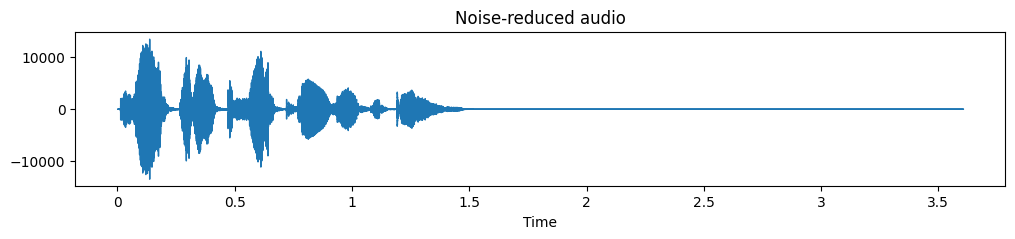

In [ ]:
final_x = nr.reduce_noise(y=padded_x, sr=sr)

plt.figure(figsize=(12,2))
librosa.display.waveshow(final_x, sr = sr)
plt.title('Noise-reduced audio')

ipd.display(ipd.Audio(data = final_x, rate=sr))

In [ ]:
# groupby the data with emotion and gender and count each value of the path
em = df.groupby(['emotion','gender']).count()
pt = em.pivot_table(index = 'emotion', columns = 'gender', values = 'File_Name')
pt

gender     female   male
emotion                 
angry        85.0   88.0
disgust      86.0   91.0
fearful      93.0   88.0
happy        89.0   90.0
neutral     138.0  133.0
sad          85.0   91.0
surprised    94.0   89.0

In [ ]:
# check the shape of the data
df.shape

(1340, 3)

In [ ]:
# Path to the directory containing the RAVDESS dataset
ravdess_data_path = "RAVDESS"  # Make sure to provide the correct path

# Function to preprocess audio file
def preprocess_audio_file(path):
    # Step 1: Load the audio file into an 'AudioSegment' object, and extract the sample rate.
    rawsound = AudioSegment.from_file(path)
    sr, x = wavfile.read(path)

    # Step 2: Normalize to +5.0 dBFS, Transform audio signals to an array.
    normalizedsound = normalize(rawsound, headroom=5.0)
    normal_x = np.array(normalizedsound.get_array_of_samples(), dtype='float32')

    # Step 3: Trim silence in the beginning and end.
    xt, index = librosa.effects.trim(normal_x, top_db=30)
    print("Length after trimming:", len(xt))  # Debugging: Print length after trimming

    if len(xt) == 0:
        print("Warning: Trimmed audio length is zero.")
        return None, sr

    # Step 4: Right-side padding for length equalization.
    max_length = 173056  # maximum lengthed audio
    padded_x = np.pad(xt, (0, max_length - len(xt)), 'constant')

    # Step 5: Reduce noise
    final_x = nr.reduce_noise(y=padded_x, sr=sr)

    return final_x, sr

# Iterate through each file in the dataset
for subdir, dirs, files in os.walk(ravdess_data_path):
    for file in files:
        # Check if file is a .wav file
        if file.endswith('.wav'):
            file_path = os.path.join(subdir, file)
            print("Processing:", file_path)

            # Preprocess the audio file
            processed_audio, sample_rate = preprocess_audio_file(file_path)

            if processed_audio is None:
                print("Skipping file due to empty trimmed audio.")
                continue

            # Display or save the processed audio if needed
            # For example, display the spectrogram
            plt.figure(figsize=(10, 4))
            librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(processed_audio)), ref=np.max), sr=sample_rate, x_axis='time', y_axis='log')
            plt.colorbar(format='%+2.0f dB')
            plt.title('Spectrogram')
            plt.show()

            # Play the processed audio
            ipd.display(ipd.Audio(data=processed_audio, rate=sample_rate))


In [ ]:
sr

48000

In [ ]:
final_x

array([-1.0694854, -0.4436208, -0.4899495, ...,  0.       ,  0.       ,
        0.       ], dtype=float32)

In [ ]:
# create a function for plotting the waveform of the data
def plot_waveform(data, sample_rate, emotion):
    plt.figure(figsize = (8,3))

    #plot waveplot
    plt.subplot(1,2,1)
    plt.title(f'Wavelet for {emotion} Emotion')
    plt.plot(np.arange(len(data))/float(sample_rate), data)
    plt.xlabel('Time(s)')
    plt.ylabel('Amplitude')

    #plot spectrogram
    plt.subplot(1,2,2)
    plt.specgram(data, Fs = sample_rate, cmap = 'viridis')
    plt.title(f'Spectrogram for {emotion} emotion')
    plt.xlabel('Time(s)')
    plt.ylabel('Frequency')

    plt.tight_layout()
    plt.show()


In [ ]:
from pydub import AudioSegment, effects

# NOISE
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

# STRETCH
def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)
# SHIFT
def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)
# PITCH
# def pitch(data, sampling_rate, pitch_factor=0.7):
#     return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

In [ ]:
# Swap keys and values
swapped_emotion_dic = {v: k for k, v in emotion.items()}
def encode(label):
    return int(swapped_emotion_dic.get(label))


*Extractes audio data and change combinations to decide the maximum accuarate givable feature set

#Experiment with different feature combinations using feature fusion

#All the features considered for feature fusion

In [ ]:
# Function to calculate zero-crossing rate
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

# Function to calculate root mean square energy
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

# Function to extract MFCC features
# Capture the spectral characteristics of the audio signal
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

# Function to calculate Spectral Centroid
# Indicates the "center of mass" of the spectrum, providing information about the brightness of the sound
def spectral_centroid(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid = librosa.feature.spectral_centroid(y=data, sr=sr)
    return np.squeeze(spectral_centroid)

# Function to calculate Spectral Bandwidth
# Measures the spread of the spectrum
def spectral_bandwidth(data, sr, frame_length=2048, hop_length=512):
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sr)
    return np.squeeze(spectral_bandwidth)

# Function to calculate Spectral Contrast
# Captures the difference in amplitude between peaks and valleys in the spectrum.
def spectral_contrast(data, sr, frame_length=2048, hop_length=512):
    spectral_contrast = librosa.feature.spectral_contrast(y=data, sr=sr)
    return np.squeeze(spectral_contrast)

# Function to extract various audio features
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])

    # Combine three types of features: ZCR, RMSE, and MFCC
    comb_1_ = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length),
                        spectral_centroid(data, sr, frame_length, hop_length),
                        spectral_bandwidth(data, sr, frame_length, hop_length),
                        spectral_contrast(data, sr, frame_length, hop_length)
                        ))
    return result




Combination_1 - MFCC, zcr & rmse

In [ ]:
# Function to calculate zero-crossing rate
# Useful for analyzing signals with varying frequencies and for detecting the periodicity of signals by analyzing pitch and timbre.
def zcr(data, frame_length, hop_length):
    zcr = librosa.feature.zero_crossing_rate(data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(zcr)

# Function to calculate root mean square energy
# Often used to compare the energy content of different signals or to characterize the overall strength or power of a signal.
def rmse(data, frame_length=2048, hop_length=512):
    rmse = librosa.feature.rms(y=data, frame_length=frame_length, hop_length=hop_length)
    return np.squeeze(rmse)

# Function to extract MFCC features
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc = librosa.feature.mfcc(y=data, sr=sr)
    return np.squeeze(mfcc.T) if not flatten else np.ravel(mfcc.T)

# Function to extract various audio features
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = np.array([])

    # Combine zero-crossing rate, root mean square energy, and MFCC features
    result = np.hstack((result,
                        zcr(data, frame_length, hop_length),
                        rmse(data, frame_length, hop_length),
                        mfcc(data, sr, frame_length, hop_length)
                        ))
    return result



combination_2 - MFCC, spectral centroid and spectral bandwidth

In [ ]:
# Function to extract MFCC features
# Capture the spectral characteristics of the audio signal
def mfcc(data, sr, frame_length=2048, hop_length=512, flatten=True):
    mfcc_result = librosa.feature.mfcc(y=data, sr=sr)
    return np.ravel(mfcc_result) if flatten else mfcc_result

# Function to calculate Spectral Centroid
# Indicates the "center of mass" of the spectrum, providing information about the brightness of the sound
def spectral_centroid(data, sr, frame_length=2048, hop_length=512):
    spectral_centroid_result = librosa.feature.spectral_centroid(y=data, sr=sr)
    return np.ravel(spectral_centroid_result)

# Function to calculate Spectral Contrast
# Captures the difference in amplitude between peaks and valleys in the spectrum.
def spectral_contrast(data, sr, frame_length=2048, hop_length=512):
    spectral_contrast_result = librosa.feature.spectral_contrast(y=data, sr=sr)
    return np.ravel(spectral_contrast_result)

# Function to extract various audio features
def extract_features(data, sr=22050, frame_length=2048, hop_length=512):
    result = []

    # MFCC feature extraction
    mfcc_features = mfcc(data, sr, frame_length, hop_length)
    if mfcc_features.size > 0:
        result.append(mfcc_features)

    # Spectral Centroid feature extraction
    spectral_centroid_features = spectral_centroid(data, sr, frame_length, hop_length)
    if spectral_centroid_features.size > 0:
        result.append(spectral_centroid_features)

    # Spectral Contrast feature extraction
    spectral_contrast_features = spectral_contrast(data, sr, frame_length, hop_length)
    if spectral_contrast_features.size > 0:
        result.append(spectral_contrast_features)

    # Concatenate feature vectors
    if len(result) > 0:
        return np.hstack(result)
    else:
        return np.array([])


In [ ]:

# Function to pitch-shift the audio
def pitch(data, sr, n_steps=2.0):
    pitched_audio = librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)
    return pitched_audio

# Function to add additive white Gaussian noise to the audio (AWGN)
def noise(data, noise_level=0.005):
    noise = np.random.normal(0, noise_level, len(data))
    return data + noise

# Function to get features from the audio file
def get_features(path, duration=2.5, offset=0.6, noise_level=0.005):
    data, sr = librosa.load(path, duration=duration, offset=offset)
    aud = extract_features(data)
    audio = np.array(aud)

    # Original audio
    noised_audio = noise(data, noise_level=noise_level)
    aud2 = extract_features(noised_audio)
    audio = np.vstack((audio, aud2))  # Add features of noised audio to the result

    # Pitch-shifted audio
    pitched_audio = pitch(data, sr)
    aud3 = extract_features(pitched_audio)
    audio = np.vstack((audio, aud3))  # Add features of pitch-shifted audio to the result

    # Pitch-shifted and noised audio
    pitched_audio1 = pitch(data, sr)
    pitched_noised_audio = noise(pitched_audio1, noise_level=noise_level)
    aud4 = extract_features(pitched_noised_audio)
    audio = np.vstack((audio, aud4))  # Add features of pitch-shifted and noised audio to the result

    return audio


In [ ]:
import timeit
import warnings
warnings.filterwarnings('ignore')
from joblib import Parallel, delayed
# from tqdm import tqdm
start = timeit.default_timer()

def process_feature(path, emotion):
    features = get_features(path)
    X = []
    Y = []
    for ele in features:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)
    return X, Y

paths = df.File_Name
emotions = df.emotion

# Run the loop in parallel
results = Parallel(n_jobs=-1)(delayed(process_feature)(path, emotion) for (path, emotion) in zip(paths, emotions))

# Collect the results
X = []
Y = []
for result in results:
    x, y = result
    X.extend(x)
    Y.extend(y)


stop = timeit.default_timer()

print('Time: ', stop - start)


Time:  409.736538566


In [ ]:
print("Shape of data after augmentation")
print("Shape of data: ", len(X))
print("Shape of target: ", len(Y))

Shape of data after augmentation
Shape of data:  5360
Shape of target:  5360


In [ ]:
Emotions = pd.DataFrame(X)
Emotions['Emotions'] = Y
Emotions.to_csv('emotion_features_processed.csv', index=False)
Emotions.head()

0           1           2           3           4           5  \
0 -829.457825 -829.457825 -829.457825 -829.457825 -829.312805 -829.457825   
1 -360.473490 -327.781362 -320.045400 -317.242156 -319.578062 -316.100480   
2 -857.058899 -857.058899 -857.058899 -857.014587 -856.939880 -856.885315   
3 -355.585277 -322.446587 -320.916608 -320.451157 -320.869582 -311.742567   
4 -783.242554 -782.825806 -776.557556 -763.960327 -757.937378 -766.970947   

            6           7           8           9  ...       3015       3016  \
0 -829.065918 -828.648865 -829.047119 -829.263367  ...  45.411904  44.246548   
1 -315.275902 -320.644671 -317.324201 -312.279187  ...  15.220063  14.094748   
2 -856.704590 -856.786926 -856.872009 -857.058899  ...  44.379617  44.886364   
3 -313.917372 -317.293939 -314.585051 -315.518213  ...  12.019994  14.262476   
4 -780.565796 -783.601868 -783.590759 -780.712158  ...  44.345423  43.956840   

        3017       3018       3019       3020       3021       3022  \
0  49.957532  46.629250  45.309079  46.252165  45.407772  30.154243   
1  13.031374  13.535161  14.111456  13.297101  13.192333  12.471060   
2  46.034470  44.645565  45.649587  44.353347  41.952462  32.115180   
3  14.852468  13.207499  13.405026  14.178714  15.010306  14.171928   
4  43.011991  45.965071  46.846970  48.568536  47.602313  33.324926   

        3023   Emotions  
0  18.989709    neutral  
1  14.128953    neutral  
2  20.160103    neutral  
3  12.502049    neutral  
4  23.331989  surprised  

[5 rows x 3025 columns]

In [ ]:
Emotions[1]

0      -829.457825
1      -327.781362
2      -857.058899
3      -322.446587
4      -782.825806
           ...    
5355   -322.967467
5356   -662.417847
5357   -326.284351
5358   -707.068359
5359   -317.710277
Name: 1, Length: 5360, dtype: float64

In [ ]:
Emotions=Emotions.fillna(0)

In [ ]:
#taking all rows and all cols without last col for X which include features
#taking last col for Y, which include the emotions

X = Emotions.iloc[: ,:-1].values
Y = Emotions['Emotions'].values

In [ ]:
# Label encoding of class variables
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
# split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state = 42, test_size = 0.2, shuffle = True)
print(f"Shape of training X : {X_train.shape}")
print(f"Shape of testing X : {X_test.shape}")
print(f"Shape of training Y : {y_train.shape}")
print(f"Shape of testing y : {y_test.shape}")

Shape of training X : (4288, 3024)
Shape of testing X : (1072, 3024)
Shape of training Y : (4288, 7)
Shape of testing y : (1072, 7)


In [ ]:
X_test[0]

array([-357.53651877, -321.26299159, -318.10090516, ...,   15.20839911,
         14.53108111,   13.03547123])

In [ ]:
y_test[0]

array([0., 0., 0., 0., 1., 0., 0.])

In [ ]:
X_train

array([[-821.8269043 , -820.30700684, -820.36676025, ...,   49.1089582 ,
          32.1197651 ,   19.32325714],
       [-354.17954087, -321.16493874, -316.96579586, ...,   17.23841317,
          17.71083894,   16.52409586],
       [-356.31997431, -319.64156601, -318.64799284, ...,   13.5021526 ,
          13.06456693,   12.45028025],
       ...,
       [-353.89387512, -320.48627452, -318.48156667, ...,   12.56827962,
          13.4893866 ,   12.75493718],
       [-597.77337646, -597.77337646, -597.77337646, ...,   49.42137585,
          36.25248176,   25.19008504],
       [-788.24121094, -788.24121094, -788.24121094, ...,   45.80396709,
          43.4381688 ,   32.34279826]])

In [ ]:
# standardizing the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train

array([[-1.19372897, -1.21184912, -1.20807597, ...,  1.20021777,
         0.98109043,  0.34330914],
       [ 0.91950587,  0.91315476,  0.92260059, ..., -0.73555904,
        -0.42983947, -0.09521473],
       [ 0.90983354,  0.91964024,  0.91548059, ..., -0.96249481,
        -0.88480496, -0.73342924],
       ...,
       [ 0.92079675,  0.91604405,  0.916185  , ..., -1.01921708,
        -0.84320638, -0.6857009 ],
       [-0.18126155, -0.26445386, -0.26593533, ...,  1.21919362,
         1.3857683 ,  1.26242161],
       [-1.04195979, -1.075335  , -1.07210254, ...,  0.99947676,
         2.08939469,  2.3829842 ]])

#Applying data to SVM & DecisionTreeClassifier

In [ ]:
# creating the model
y_train_labels = np.argmax(y_train, axis=1)
svm_model = LinearSVC()
# fitting the data into model
svm_model.fit(X_train, y_train_labels)

LinearSVC()

In [ ]:
# predict the test data
y_pred = svm_model.predict(X_test)

In [ ]:
y_pred[2]

5

In [ ]:
# calculating the performance of the model by performance metrics
y_test_labels = np.argmax(y_test, axis=1)
accuracy_svm = accuracy_score(y_pred,y_test_labels)
precision_svm = precision_score(y_pred,y_test_labels, average='weighted')
recall_svm = recall_score(y_pred, y_test_labels, average='weighted')
classificationReport_svm = classification_report(y_pred, y_test_labels)

# print the performance metrics
print(f"Accuracy of the SVM Model : {accuracy_svm}")
print(f"Precision of the SVM Model : {precision_svm}")
print(f"Recall of the SVM Model : {recall_svm}")
print(f"Classification Report : {classificationReport_svm}")


Accuracy of the SVM Model : 0.6166044776119403
Precision of the SVM Model : 0.6169596892359813
Recall of the SVM Model : 0.6166044776119403
Classification Report :               precision    recall  f1-score   support

           0       0.75      0.77      0.76       132
           1       0.59      0.63      0.61       126
           2       0.57      0.59      0.58       130
           3       0.53      0.55      0.54       145
           4       0.69      0.65      0.67       235
           5       0.45      0.42      0.44       146
           6       0.69      0.68      0.69       158

    accuracy                           0.62      1072
   macro avg       0.61      0.61      0.61      1072
weighted avg       0.62      0.62      0.62      1072



In [ ]:
dt_model = DecisionTreeClassifier(criterion = 'entropy',max_depth = 5)
dt_model.fit(X_train,y_train_labels)

DecisionTreeClassifier(criterion='entropy', max_depth=5)

In [ ]:
# testing the model on test data
y_pred = dt_model.predict(X_test)

In [ ]:
# calculating the performance of the algorithms
accuracy_dt = accuracy_score(y_pred, y_test_labels)
precision_dt = precision_score(y_pred, y_test_labels, average = 'weighted')
recall_dt = recall_score(y_pred, y_test_labels, average = 'weighted')
classificationReport_dt = classification_report(y_pred, y_test_labels)

# print the performance metrics
print(f"Accuracy of the Deision Tree Model : {accuracy_dt}")
print(f"Precision of the Deision Tree : {precision_dt}")
print(f"Recall of the Deision Tree : {recall_dt}")
print("Classification Report:")
print(classificationReport_dt)

Accuracy of the Deision Tree Model : 0.3423507462686567
Precision of the Deision Tree : 0.5476608947531895
Recall of the Deision Tree : 0.3423507462686567
Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.75      0.32        36
           1       0.59      0.28      0.38       287
           2       0.09      0.35      0.14        34
           3       0.05      0.27      0.08        26
           4       0.55      0.54      0.54       229
           5       0.12      0.40      0.18        40
           6       0.65      0.24      0.35       420

    accuracy                           0.34      1072
   macro avg       0.32      0.40      0.29      1072
weighted avg       0.55      0.34      0.38      1072



In [ ]:
# make the data farme of the result
result_df = pd.DataFrame({
    "Model": ['SVM', 'Decision Tree'],
    "Accuracy": [accuracy_svm,accuracy_dt],
    "Precision" : [precision_svm, precision_dt],
    "Recall" : [recall_svm,recall_dt]
})
result_df

Model  Accuracy  Precision    Recall
0            SVM  0.616604   0.616960  0.616604
1  Decision Tree  0.342351   0.547661  0.342351

#Applying data for Neural Network CNN

In [ ]:
# Reshaping the data for CNN Model
X_train_cnn = np.expand_dims(X_train, axis = 2)
X_test_cnn = np.expand_dims(X_test, axis = 2)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization, LSTM, Flatten, Dense, Dropout
from keras.layers import TimeDistributed

# Build a Sequential model
model = Sequential()

# 1st Convolution Block
model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

# 2nd Convolution Block
model.add(Conv1D(64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

# 3rd Convolution Block
model.add(Conv1D(128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

# 4th Convolution Block
model.add(Conv1D(32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=3, strides=2, padding='same'))

# LSTM Layer
model.add(LSTM(64, return_sequences=True))
#model.add(LSTM(64))

# Flatten the output for Dense layers
model.add(Flatten())

# Fully Connected Layers
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Output Layer (for multi-class classification, e.g., 7 emotion categories)
model.add(Dense(7, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 3024, 128)           │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 3024, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 1512, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1512, 64)            │          24,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1512, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 756, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 756, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 756, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 378, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 378, 32)             │          12,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 378, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 189, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 189, 64)             │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 12096)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,548,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,0

 Total params: 1,647,911 (6.29 MB)

 Trainable params: 1,646,951 (6.28 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# train the data
history=model.fit(X_train_cnn, y_train, epochs=18, validation_data=(X_test_cnn, y_test), batch_size=64)

Epoch 1/18
67/67 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.3364 - loss: 1.7440 - val_accuracy: 0.2080 - val_loss: 3.8665
Epoch 2/18
67/67 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.5703 - loss: 1.1622 - val_accuracy: 0.2118 - val_loss: 4.0216
Epoch 3/18
67/67 ━━━━━━━━━━━━━━━━━━━━ 185s 3s/step - accuracy: 0.6922 - loss: 0.8678 - val_accuracy: 0.2127 - val_loss: 3.6855
Epoch 4/18
67/67 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.7848 - loss: 0.5971 - val_accuracy: 0.2528 - val_loss: 3.5564
Epoch 5/18
67/67 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.8351 - loss: 0.4535 - val_accuracy: 0.3769 - val_loss: 2.4115
Epoch 6/18
67/67 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9084 - loss: 0.2782 - val_accuracy: 0.4226 - val_loss: 2.7860
Epoch 7/18
67/67 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.9115 - loss: 0.2403 - val_accuracy: 0.6446 - val_loss: 1.2883
Epoch 8/18
67/67 ━━━━━━━━━━━━━━━━━━━━ 212s 3s/step - accuracy: 0.9391 - loss: 0.1822 - val_accuracy: 0.6511 - v

In [ ]:
# caculating the loss and accuracy of the model
loss, accuracy = model.evaluate(X_test_cnn,y_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 194ms/step - accuracy: 0.7172 - loss: 1.3045


In [ ]:
y_test

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [ ]:
y_pred

array([1, 1, 6, ..., 4, 6, 5])

In [ ]:
array = y_pred
emotion_mapping = {
    '03': 'happy',
    '01': 'neutral',
    '02': 'neutral',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

for value, emotion_code in zip(array, map(str, array)):
    emotion = emotion_mapping.get(emotion_code.zfill(2), 'Unknown')
    print(f"Prediction: {value}, Emotion: {emotion}")


Prediction: 1, Emotion: neutral
Prediction: 1, Emotion: neutral
Prediction: 6, Emotion: fearful
Prediction: 2, Emotion: neutral
Prediction: 4, Emotion: sad
Prediction: 1, Emotion: neutral
Prediction: 4, Emotion: sad
Prediction: 1, Emotion: neutral
Prediction: 1, Emotion: neutral
Prediction: 6, Emotion: fearful
Prediction: 1, Emotion: neutral
Prediction: 1, Emotion: neutral
Prediction: 6, Emotion: fearful
Prediction: 6, Emotion: fearful
Prediction: 1, Emotion: neutral
Prediction: 6, Emotion: fearful
Prediction: 6, Emotion: fearful
Prediction: 1, Emotion: neutral
Prediction: 1, Emotion: neutral
Prediction: 6, Emotion: fearful
Prediction: 6, Emotion: fearful
Prediction: 6, Emotion: fearful
Prediction: 4, Emotion: sad
Prediction: 4, Emotion: sad
Prediction: 6, Emotion: fearful
Prediction: 6, Emotion: fearful
Prediction: 6, Emotion: fearful
Prediction: 6, Emotion: fearful
Prediction: 4, Emotion: sad
Prediction: 5, Emotion: angry
Prediction: 5, Emotion: angry
Prediction: 6, Emotion: fearful


In [ ]:
yy_pred = model.predict(X_test_cnn)


34/34 ━━━━━━━━━━━━━━━━━━━━ 11s 286ms/step


In [ ]:
yy_pred

array([[7.18572892e-06, 1.30748216e-04, 4.98947848e-05, ...,
        8.18361808e-03, 9.91594315e-01, 1.98907060e-06],
       [3.21133484e-08, 9.99999940e-01, 6.53955912e-09, ...,
        2.60419086e-09, 2.93291702e-09, 3.50442186e-09],
       [3.41127394e-04, 8.45302246e-04, 2.27554631e-03, ...,
        2.71293311e-06, 2.32152850e-03, 5.88594377e-01],
       ...,
       [2.41521292e-07, 1.05570625e-05, 5.05894459e-05, ...,
        9.97988760e-01, 1.94928783e-03, 2.88182918e-07],
       [6.47124807e-06, 9.99778271e-01, 1.66007374e-06, ...,
        1.13163571e-06, 1.79385883e-04, 4.42223836e-06],
       [7.49636464e-10, 9.99999940e-01, 3.82770232e-10, ...,
        3.67063491e-09, 2.11667626e-08, 4.17406909e-09]], dtype=float32)

In [ ]:
import numpy as np

# Convert probabilities to class labels
y_pred_classes = np.argmax(yy_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Get a classification report
report = classification_report(y_true_classes, y_pred_classes, target_names=['happy', 'neutral', 'sad', 'angry', 'fearful', 'disgust', 'surprised'])
print(report)


              precision    recall  f1-score   support

       happy       0.94      0.57      0.71       134
     neutral       0.58      0.90      0.71       135
         sad       0.72      0.64      0.68       135
       angry       0.69      0.75      0.72       150
     fearful       0.88      0.64      0.74       223
     disgust       0.53      0.72      0.61       139
   surprised       0.84      0.80      0.82       156

    accuracy                           0.71      1072
   macro avg       0.74      0.72      0.71      1072
weighted avg       0.75      0.71      0.72      1072



In [ ]:
# Get confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)


[[ 77  33   1  15   2   3   3]
 [  3 121   2   1   1   6   1]
 [  0  12  86  10   2  16   9]
 [  1   8  11 113   4   8   5]
 [  1   8   6   8 142  53   5]
 [  0  11   9   8  10 100   1]
 [  0  15   4   9   0   3 125]]
